In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import csv

from scipy import stats
from collections import Counter
from scripts import regression, plot_utils, cohort_utils
from scipy.stats import mannwhitneyu, ks_2samp, chisquare, chi2_contingency, ttest_ind, ranksums
from statsmodels.stats.proportion import proportions_ztest
from scripts.load_data import load_all_faculty
import statsmodels.formula.api as smf

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

color_mapping = {'CS': ('#5777D9', '#293866'), 
                 'Business': ('#CC3A35', '#661D1B'), 
                 'History': ('#8BCC60', '#466630')}

%matplotlib inline

In [2]:
df = load_all_faculty()

WARNING *** file size (1595918) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (3460610) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [3]:
df.likely_department.value_counts()

Business            1321
Computer Science    1139
History              992
Name: likely_department, dtype: int64

In [4]:
canadian_universities = ['University of Waterloo', 'University of Alberta', 'University of Western Ontario', 
                         'York University', 'University of Toronto', 'University of Ottawa', 
                         'Carleton University', 'Concordia University, Montreal', 'University of Calgary', 
                         'McGill University', 'University of Montreal', 'University of Saskatchewan', 
                         'University of British Columbia', 'University of New Brunswick', 
                         'Memorial University of Newfoundland', 'Queens University', 'Simon Fraser University', 
                         'University of Regina', 'University of Manitoba', 'Dalhousie University', 
                         'McMaster University']

## Response rate

In [5]:
df[df.likely_department == "Computer Science"].shape[0], \
df[df.likely_department == "Business"].shape[0], \
df[df.likely_department == "History"].shape[0], \
df.shape[0] # Total number of responses

(1139, 1321, 992, 3452)

In [6]:
# Total number of departments across the three fields
len(df[df.likely_department == "Computer Science"].university_name_standard.dropna().unique()), \
len(df[df.likely_department == "Business"].university_name_standard.dropna().unique()), \
len(df[df.likely_department == "History"].university_name_standard.dropna().unique()), \
(200+113+140)

(200, 113, 140, 453)

## Total publications

In [7]:
pub_count = 0
for each in df['dblp_pubs'].dropna():
    pub_count += len(each)
print(pub_count)

100972


In [8]:
print(len(df[df.likely_department == "Business"]['dblp_pubs'].dropna()), 
      len(df[df.likely_department == "Business"]['dblp_pubs']),
      len(df[df.likely_department == "Business"]['dblp_pubs'].dropna()) / \
      len(df[df.likely_department == "Business"]['dblp_pubs']))
pub_count = 0
for each in df[df.likely_department == "Business"]['dblp_pubs'].dropna():
    pub_count += len(each)
print(pub_count)

525 1321 0.39742619227857684
15352


In [9]:
print(len(df[df.likely_department == "History"]['dblp_pubs'].dropna()),
      len(df[df.likely_department == "History"]['dblp_pubs']),
      len(df[df.likely_department == "History"]['dblp_pubs'].dropna()) / \
      len(df[df.likely_department == "History"]['dblp_pubs']))
pub_count = 0
for each in df[df.likely_department == "History"]['dblp_pubs'].dropna():
    pub_count += len(each)
print(pub_count)

294 992 0.2963709677419355
6346


In [10]:
print(len(df[df.likely_department == "Computer Science"]['dblp_pubs'].dropna()), 
      len(df[df.likely_department == "Computer Science"]['dblp_pubs'].dropna()) / \
      len(df[df.likely_department == "Computer Science"]['dblp_pubs']))
pub_count = 0
for each in df[df.likely_department == "Computer Science"]['dblp_pubs'].dropna():
    pub_count += len(each)
print(pub_count)

1061 0.9315188762071993
79274


## Mothers over time

In [11]:
first_kid_birth = df.loc[:, ['chage1', 'chage2', 'chage3', 'chage3', 'chage4', 
                             'chage5', 'chage6', 'chage7', 'chage8', 'chage9']].min(axis=1)

## Differences between mothers and fathers who had kids

378 3074


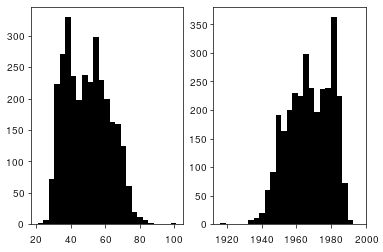

In [12]:
fig, ax = plt.subplots(1, 2)
(2017 - df['age_coded']).hist(color='black', grid=False, bins=25, ax=ax[0])
(df['age_coded']).hist(color='black', grid=False, bins=25, ax=ax[1])
print((2017 - df['age_coded']).isna().sum(), (2017 - df['age_coded']).notna().sum())

In [13]:
completed_first_page = (df.children.isin([1.0,2.0]) & (df.gender_ans > 0) & (df.age_coded > 0) & 
                        (~df.prestige_inv.isna()))
df['at_least_40_yo'] = ((2017 - df['age_coded']) >= 40)
df['had_children'] = df.children.apply(lambda x: x == 2)

In [14]:
df[df.at_least_40_yo & completed_first_page].had_children.value_counts(normalize=True)

True     0.787177
False    0.212823
Name: had_children, dtype: float64

In [15]:
df[df.at_least_40_yo & (df['gender_ans'] == 2.0) & completed_first_page].had_children.value_counts(
    normalize=True)

True     0.822266
False    0.177734
Name: had_children, dtype: float64

In [16]:
df[df.at_least_40_yo & (df['gender_ans'] == 1.0) & completed_first_page].had_children.value_counts(
    normalize=True)

True     0.709957
False    0.290043
Name: had_children, dtype: float64

In [17]:
count = np.array([sum(df[df.at_least_40_yo & (df['gender_ans'] == 1.0) & 
                         completed_first_page].children == 1), 
                  sum(df[df.at_least_40_yo & (df['gender_ans'] == 2.0) & 
                         completed_first_page].children == 1)])
nobs = np.array([sum(df[df.at_least_40_yo & (df['gender_ans'] == 1.0) & 
                        completed_first_page].children.isin([1.0, 2.0])), 
                 sum(df[df.at_least_40_yo & (df['gender_ans'] == 2.0) & 
                        completed_first_page].children.isin([1.0, 2.0]))])
proportions_ztest(count, nobs)

(5.9979626900882135, 1.9980841164377015e-09)

<AxesSubplot:>

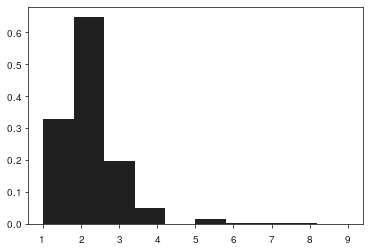

In [18]:
had_kids = df[completed_first_page & (df['children_no'] > 0)]
had_kids['children_no'].hist(density=True, color=plot_utils.ALMOST_BLACK, grid=False)

In [19]:
# Statistical tests between the means & medians
print(had_kids[had_kids.gender_ans == 2]['children_no'].mean(),
      had_kids[had_kids.gender_ans == 1]['children_no'].mean())
print(ttest_ind(had_kids[had_kids.gender_ans == 2]['children_no'], 
               had_kids[had_kids.gender_ans == 1]['children_no']))
# print(ks_2samp(had_kids[had_kids.gender_ans == 2]['children_no'], 
#               had_kids[had_kids.gender_ans == 1]['children_no']))

2.1617742987606 1.8328025477707006
Ttest_indResult(statistic=7.172584956774222, pvalue=1.0067887882800357e-12)


In [20]:
print(had_kids[had_kids.gender_ans == 2]['children_no'].median(),
      had_kids[had_kids.gender_ans == 1]['children_no'].median())

2.0 2.0


Do mothers have fewer children because they can't afford more career-wise, or because they have less time to produce children compared to men (up to 40-ish vs much later for men)? Not sure what to do about this except perhaps report a test which controls for age (e.g. some regression analysis).

In [21]:
had_kids_copy = had_kids.copy(deep=True)
had_kids_copy = had_kids_copy[had_kids_copy.gender_ans.isin([1, 2])]
had_kids_copy['is_female'] = had_kids_copy['gender_ans'].apply(lambda x: True if x == 1 else False)

age_children_mod = smf.ols(formula = 'children_no ~ C(is_female)*age_coded', 
                           data = had_kids_copy)
age_children_res = age_children_mod.fit()
age_children_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            children_no   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     24.96
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           7.18e-16
Time:                        11:32:37   Log-Likelihood:                -2983.8
No. Observations:                2161   AIC:                             5976.
Df Residuals:                    2157   BIC:                             5998.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         16.8353      3.999      4.210      0.000       8.992      24.678
C(is_female)[T.True]               6.9210      8.173      0.847      0.397      -9.106      22.948
age_coded                         -0.0075      0.002     -3.669      0.000      -0.011      -0.003
C(is_female)[T.True]:age_coded    -0.0037      0.004     -0.883      0.377      -0.012       0.004
==============================================================================
Omnibus:                      981.538   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7268.715
Skew:                           1.991   Prob(JB):                         0.00
Kurtosis:                      11.054   Cond. No.                     8.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

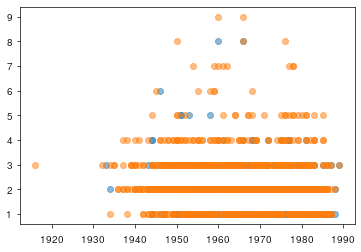

In [22]:
plt.scatter(had_kids[had_kids.gender_ans == 1]['age_coded'], 
            had_kids[had_kids.gender_ans == 1]['children_no'], alpha=0.5)
plt.scatter(had_kids[had_kids.gender_ans == 2]['age_coded'], 
            had_kids[had_kids.gender_ans == 2]['children_no'], alpha=0.5)

In [23]:
men_kid_dist = [(df[completed_first_page & (df.gender_ans == 2)]['children_no'] == i).sum() for i in range(1, 9)]
women_kid_dist = [(df[completed_first_page & (df.gender_ans == 1)]['children_no'] == i).sum() for i in range(1, 9)]

print(chi2_contingency([women_kid_dist, men_kid_dist], correction=False))

(62.80812106340945, 4.140900815392734e-11, 7, array([[163.76285317, 326.36220472,  99.1885132 ,  25.01528485,
          7.85363594,   2.03612784,   2.32700324,   1.45437703],
       [399.23714683, 795.63779528, 241.8114868 ,  60.98471515,
         19.14636406,   4.96387216,   5.67299676,   3.54562297]]))


Essentially, there exists statistically significant differences in the means and distributions of children for men and women.

In [24]:
df['age_at_parenthood'] = df['chage1'] - df['age_coded']

In [25]:
print(df[completed_first_page & (df['gender_ans'] == 2)].age_at_parenthood.mean(),
      df[completed_first_page & (df['gender_ans'] == 1)].age_at_parenthood.mean())

32.75967957276369 33.035369774919616


In [26]:
print(df[completed_first_page & (df.likely_department == 'Computer Science') & 
         (df['gender_ans'] == 2)].age_at_parenthood.mean(),
      df[completed_first_page & (df.likely_department == 'Computer Science') & 
         (df['gender_ans'] == 1)].age_at_parenthood.mean())

32.60725552050473 32.80392156862745


In [27]:
print(df[completed_first_page & (df.likely_department == 'Business') & 
         (df['gender_ans'] == 2)].age_at_parenthood.mean(),
      df[completed_first_page & (df.likely_department == 'Business') & 
         (df['gender_ans'] == 1)].age_at_parenthood.mean())

32.149253731343286 31.986547085201792


In [28]:
print(df[completed_first_page & (df.likely_department == 'History') & 
         (df['gender_ans'] == 2)].age_at_parenthood.mean(),
      df[completed_first_page & (df.likely_department == 'History') & 
         (df['gender_ans'] == 1)].age_at_parenthood.mean())

34.051829268292686 34.13008130081301


In [29]:
ttest_ind(
    df[completed_first_page & (df['gender_ans'] == 2)].age_at_parenthood.dropna(),
    df[completed_first_page & (df['gender_ans'] == 1)].age_at_parenthood.dropna()
)

Ttest_indResult(statistic=-1.0448263106453783, pvalue=0.2962224823398604)

In [30]:
pi_mod = smf.ols(data = pd.DataFrame({'age': (df[completed_first_page]['age_at_parenthood']), 
                                      'pi':   df[completed_first_page]['prestige_inv']}),
                 formula = 'age ~ pi')
pi_res = pi_mod.fit()

pi_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.451
Date:                Tue, 26 Jan 2021   Prob (F-statistic):            0.00639
Time:                        11:32:37   Log-Likelihood:                -6721.4
No. Observations:                2135   AIC:                         1.345e+04
Df Residuals:                    2133   BIC:                         1.346e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.3804      0.223    149.365      0.000      32.942      33.819
pi            -0.0074      0.003     -2.730      0.006      -0.013      -0.002
==============================================================================
Omnibus:                      401.454   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1946.446
Skew:                           0.810   Prob(JB):                         0.00
Kurtosis:                       7.388   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
parents = df[completed_first_page & df['had_children']]
not_parents = df[completed_first_page & ~df['had_children']]

print(parents.prestige_inv.mean(), not_parents.prestige_inv.mean(), 
      ks_2samp(parents.prestige_inv, not_parents.prestige_inv))

68.876796875 68.10647058823528 KstestResult(statistic=0.03478506787330317, pvalue=0.42120689634871333)


<AxesSubplot:>

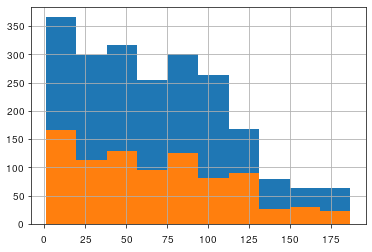

In [32]:
parents.prestige_inv.hist()
not_parents.prestige_inv.hist()

In [33]:
df['prestige_decile'] = pd.qcut(df.prestige_inv, 10, labels=range(1, 11))

In [34]:
parents = df[completed_first_page & df['had_children']].prestige_decile.astype(float)
not_parents = df[completed_first_page & ~df['had_children']].prestige_decile.astype(float)

print(parents.mean(), not_parents.mean(), ks_2samp(parents, not_parents))

5.561580882352941 5.501131221719457 KstestResult(statistic=0.030542986425339366, pvalue=0.5879182456530134)


In [35]:
def child_before_tt(row):
    if row.had_children:
        return row.chage1 < row.first_asst_job_year
    return False

df['child_before_tt'] = df.apply(child_before_tt, axis=1)
df[completed_first_page & df.had_children]['child_before_tt'].value_counts(normalize=True)

False    0.605239
True     0.394761
Name: child_before_tt, dtype: float64

In [36]:
mapping = {2: 'M', 1: 'F', 3: 'NB', 4: 'NA', 0: 'NA', -77: 'NA'}
df['resp_gender'] = df['gender_ans'].apply(lambda x: mapping[x])
columns_to_include = ['resp_gender', 'had_children', 'prestige_decile', 'child_before_tt', 'at_least_40_yo']
df[completed_first_page & 
   df.resp_gender.isin(['M', 'F'])][columns_to_include].to_csv('../data/general_parenthood_demographics.tsv', 
                                                               index=False, sep='\t')

## How important do people think parental leave is?

<AxesSubplot:title={'center':'Imp. of Parental Leave'}>

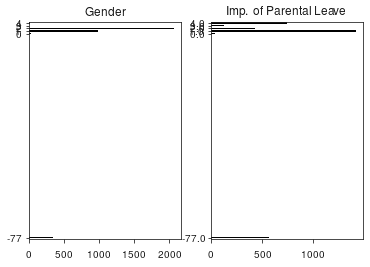

In [37]:
fig, ax = plt.subplots(1, 2)
df.gender_ans.value_counts().plot(kind='barh', ax=ax[0], title='Gender', color='black')
df.current_parleave.value_counts().plot(kind='barh', ax=ax[1], title='Imp. of Parental Leave', color='black')

In [38]:
covars = ['current_parleave', 'current_rank', 'current_partner'] #'current_geo','current_money']
title = 'Importance in choosing current academic position: `%s`' 

for var in covars:
    temp = df[['gender_ans',var]].dropna()
    temp = temp[(temp[var] < 4) &  (temp[var] > 0)] # -77 is missing. #1 not, 2 somewhat, 3 veryimp, 4 na
    temp = temp.groupby(['gender_ans', var]).size().unstack().T

    print()
    print(title % var)
    print('Are the two different? pval =', stats.chi2_contingency(temp.values[:,0:2], correction=False))
    normed = temp.div(temp.sum(axis=0), axis=1)
    print(normed)
    print('women: %.4f' % normed[1][normed[1].index.isin([2, 3])].sum(), 
          'men: %.4f' % normed[2][normed[2].index.isin([2, 3])].sum(), 
         )


Importance in choosing current academic position: `current_parleave`
Are the two different? pval = (141.8132183005639, 1.6056501180343274e-31, 2, array([[423.65903308, 987.34096692],
       [128.2086514 , 298.7913486 ],
       [ 38.13231552,  88.86768448]]))
gender_ans               1         2    3         4
current_parleave                                   
1.0               0.540678  0.794182  1.0  0.750000
2.0               0.328814  0.169455  NaN  0.166667
3.0               0.130508  0.036364  NaN  0.083333
women: 0.4593 men: 0.2058

Importance in choosing current academic position: `current_rank`
Are the two different? pval = (0.7660474480780001, 0.681796724122048, 2, array([[ 90.82988333, 188.17011667],
       [423.87278886, 878.12721114],
       [350.29732781, 725.70267219]]))
gender_ans           1         2         3         4
current_rank                                        
1.0           0.100578  0.107143  0.333333  0.076923
2.0           0.501734  0.484375  0.333333 

In [39]:
covars = ['other_parleave', 'other_rank'] #'other_geo', 'other_money', 'other_partner']
title = 'Importance in choosing future academic position: `%s`' 

for var in covars:
    temp = df[['gender_ans',var]].dropna()
    temp = temp[(temp[var] < 4) &  (temp[var] > 0)]
    temp = temp.groupby(['gender_ans', var]).size().unstack().T

    print()
    print(title % var)
    print('Are the two different? pval =', stats.chi2_contingency(temp.values[:,0:2], correction=False))
    normed = temp.div(temp.sum(axis=0), axis=1)
    print(normed)
    print('women: %.4f' % normed[1][normed[1].index.isin([2, 3])].sum(), 
          'men: %.4f' % normed[2][normed[2].index.isin([2, 3])].sum(), 
         )


Importance in choosing future academic position: `other_parleave`
Are the two different? pval = (76.47644944570258, 2.473716951199911e-17, 2, array([[ 619.919939  , 1293.080061  ],
       [ 159.11170416,  331.88829584],
       [  70.96835684,  148.03164316]]))
gender_ans             1         2    3         4
other_parleave                                   
1.0             0.641176  0.771574  0.5  0.857143
2.0             0.212941  0.174845  0.5  0.071429
3.0             0.145882  0.053582  NaN  0.071429
women: 0.3588 men: 0.2284

Importance in choosing future academic position: `other_rank`
Are the two different? pval = (0.3478384068909802, 0.8403647934953655, 2, array([[360.39137075, 756.60862925],
       [305.86483391, 642.13516609],
       [178.74379534, 375.25620466]]))
gender_ans         1         2    3         4
other_rank                                   
1.0         0.430769  0.424464  0.5  0.428571
2.0         0.364497  0.360767  0.5  0.500000
3.0         0.204734  0.2147


[[3.190e+02 1.092e+03 2.000e+00 9.000e+00]
 [1.940e+02 2.330e+02       nan 2.000e+00]
 [7.700e+01 5.000e+01       nan 1.000e+00]]
Importance in choosing current academic position
Are the two different? pval = (141.8132183005639, 1.6056501180343274e-31, 2, array([[423.65903308, 987.34096692],
       [128.2086514 , 298.7913486 ],
       [ 38.13231552,  88.86768448]]))
gender_ans               1         2    3         4
current_parleave                                   
1.0               0.540678  0.794182  1.0  0.750000
2.0               0.328814  0.169455  NaN  0.166667
3.0               0.130508  0.036364  NaN  0.083333
women: 0.4593 men: 0.2058

[[5.450e+02 1.368e+03 1.000e+00 1.200e+01]
 [1.810e+02 3.100e+02 1.000e+00 1.000e+00]
 [1.240e+02 9.500e+01       nan 1.000e+00]]
Importance in choosing another academic position
Are the two different? pval = (76.47644944570258, 2.473716951199911e-17, 2, array([[ 619.919939  , 1293.080061  ],
       [ 159.11170416,  331.88829584],
       [  

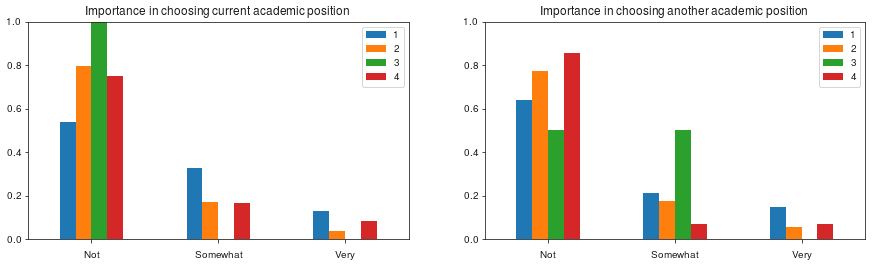

In [40]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

covars = ['current_parleave', 'other_parleave']
titles = ['Importance in choosing current academic position',
         'Importance in choosing another academic position']

for var, title, ax in zip(covars, titles, axs):
    temp = df[['gender_ans', var]].dropna()
    temp = temp[(temp[var] < 4) &  (temp[var] > 0)]
    temp = temp.groupby(['gender_ans', var]).size().unstack().T
    b = temp.div(temp.sum(axis=0), axis=1).plot.bar(ax=ax)

    ax.set_title(title)
    ax.set_xticklabels(['Not', 'Somewhat', 'Very'], rotation=0)
    ax.set_xlabel("")
    ax.legend()
    ax.set_ylim(0,1)

    print()
    print(temp.values)
    print(title)
    print('Are the two different? pval =', stats.chi2_contingency(temp.values[:,0:2], correction=False))
    normed = temp.div(temp.sum(axis=0), axis=1)
    print(normed)
    print('women: %.4f' % normed[1][normed[1].index.isin([2, 3])].sum(), 
          'men: %.4f' % normed[2][normed[2].index.isin([2, 3])].sum(), 
         )

plt.show()

#### Takeaways:
* Women indicate higher importance for parental support than men
    * Half of women indicate it was an important factor in choosing their current position (compared to a quarter of men; important = somwhat or very important)
* Importance goes down for both genders when considering next position (reasonable: more relevant for younger faculty)
* Women and men see institution rank as equally important for choosing their current or another academic position.

### How does parental leave compare to other job attributes, like rank?

In [41]:
temp = df[df['gender_ans'].isin([1, 2])][['gender_ans','current_parleave','current_rank']].dropna()
temp = temp[(temp['current_parleave'] < 4) & (temp['current_rank'] < 4)]
temp['parleave-vs-rank'] = temp.current_parleave >= temp.current_rank

"""Fraction of Men and Women who report parental leave as being at least as important as
   the rank of the university."""
temp = temp.groupby(['gender_ans', 'parleave-vs-rank']).size().unstack().T
print(temp.values)
print('pval', stats.chi2_contingency(temp.values, correction=False)[1])
temp.div(temp.sum(axis=0), axis=1)

[[ 355 1059]
 [ 309  460]]
pval 2.598846041456246e-13


gender_ans,1,2
parleave-vs-rank,,
False,0.534639,0.697169
True,0.465361,0.302831


Takeaways: 46% of women indicate parental support was (at least) __as important as rank__ for choosing their current posotion (compared to 31% of men)

## How many men and women are taking leave?

In [42]:
parleave_elig = ['parleave_elig_child1','parleave_elig_child2','parleave_elig_child3','parleave_elig_child4']
df['count_eligible'] = df[parleave_elig].apply(lambda x: x == 2, axis=1).sum(axis=1)

In [43]:
parleave_taken = ['parleave_taken_child1','parleave_taken_child2','parleave_taken_child3',
                  'parleave_taken_child4']
df['count_took_some_leave'] = df[parleave_taken].apply(lambda x: x >= 2, axis=1).sum(axis=1)

In [44]:
# Must be the case that you were eligible for more (or equal) leave than you took
assert (df['count_eligible'] >= df['count_took_some_leave']).all()

In [45]:
df['frac_took_leave'] = df['count_took_some_leave']/df['count_eligible']

In [46]:
# How many men / women took leave at least once (if they were eligible)?
men_offered_leave = df[(df.gender_ans == 2) & (df.count_eligible > 0)]
print((men_offered_leave.count_took_some_leave > 0).sum(), 
      (men_offered_leave.count_took_some_leave == 0).sum(),
      len(men_offered_leave), 
      (men_offered_leave.count_took_some_leave > 0).sum()/len(men_offered_leave)
     )

246 150 396 0.6212121212121212


In [47]:
men_offered_leave.children.value_counts()

2.0    396
Name: children, dtype: int64

In [48]:
women_offered_leave = df[(df.gender_ans == 1) & (df.count_eligible > 0)]
print((women_offered_leave.count_took_some_leave > 0).sum(), 
      (women_offered_leave.count_took_some_leave == 0).sum(),
      len(women_offered_leave),
      (women_offered_leave.count_took_some_leave > 0).sum()/len(women_offered_leave)
     )

301 27 328 0.9176829268292683


In [49]:
women_offered_leave.children.value_counts()

2.0    328
Name: children, dtype: int64

In [50]:
count = np.array([(women_offered_leave.count_took_some_leave > 0).sum(), 
                  (men_offered_leave.count_took_some_leave > 0).sum()])
nobs = np.array([len(women_offered_leave), len(men_offered_leave)])

proportions_ztest(count, nobs, alternative='larger')

(9.23964818556579, 1.2365451892921541e-20)

In [51]:
# How many men took leave at least once (if they were eligible) before / after 2000?
men_offered_leave_pre_2000 = men_offered_leave[men_offered_leave.chage1 < 2000]
print((men_offered_leave_pre_2000.count_took_some_leave > 0).sum(), 
      (men_offered_leave_pre_2000.count_took_some_leave == 0).sum(),
      len(men_offered_leave_pre_2000), 
      (men_offered_leave_pre_2000.count_took_some_leave > 0).sum()/len(men_offered_leave_pre_2000)
     )

men_offered_leave_post_2000 = men_offered_leave[men_offered_leave.chage1 >= 2000]
print((men_offered_leave_post_2000.count_took_some_leave > 0).sum(), 
      (men_offered_leave_post_2000.count_took_some_leave == 0).sum(),
      len(men_offered_leave_post_2000),
      (men_offered_leave_post_2000.count_took_some_leave > 0).sum()/len(men_offered_leave_post_2000)
     )

count = np.array([(men_offered_leave_post_2000.count_took_some_leave > 0).sum(), 
                  (men_offered_leave_pre_2000.count_took_some_leave > 0).sum()])
nobs = np.array([len(men_offered_leave_post_2000), len(men_offered_leave_pre_2000)])

proportions_ztest(count, nobs, alternative='larger')

29 46 75 0.38666666666666666
213 102 315 0.6761904761904762


(4.643697872123712, 1.7111395759808787e-06)

In [52]:
# How many men took leave at least once (if they were eligible): Canada vs US
men_offered_leave_us = df[(df.gender_ans == 2) & (df.count_eligible > 0) & 
                          (~df.university_name_standard.isin(canadian_universities))]
print((men_offered_leave_us.count_took_some_leave > 0).sum(), 
      (men_offered_leave_us.count_took_some_leave == 0).sum(),
      len(men_offered_leave_us), 
      (men_offered_leave_us.count_took_some_leave > 0).sum()/len(men_offered_leave_us)
     )

men_offered_leave_can = df[(df.gender_ans == 2) & (df.count_eligible > 0) & 
                           (df.university_name_standard.isin(canadian_universities))]
print((men_offered_leave_can.count_took_some_leave > 0).sum(), 
      (men_offered_leave_can.count_took_some_leave == 0).sum(),
      len(men_offered_leave_can),
      (men_offered_leave_can.count_took_some_leave > 0).sum()/len(men_offered_leave_can)
     )

count = np.array([(men_offered_leave_us.count_took_some_leave > 0).sum(), 
                  (men_offered_leave_can.count_took_some_leave > 0).sum()])
nobs = np.array([len(men_offered_leave_us), len(men_offered_leave_can)])

proportions_ztest(count, nobs, alternative='two-sided')

230 130 360 0.6388888888888888
16 20 36 0.4444444444444444


(2.2931499264910378, 0.021839374841819702)

In [53]:
# How many men took leave at least once (if they were eligible): Canada vs US
women_offered_leave_us = df[(df.gender_ans == 1) & (df.count_eligible > 0) & 
                           (~df.university_name_standard.isin(canadian_universities))]
print((women_offered_leave_us.count_took_some_leave > 0).sum(), 
      (women_offered_leave_us.count_took_some_leave == 0).sum(),
      len(women_offered_leave_us), 
      (women_offered_leave_us.count_took_some_leave > 0).sum()/len(women_offered_leave_us)
     )

women_offered_leave_can = df[(df.gender_ans == 1) & (df.count_eligible > 0) & 
                             (df.university_name_standard.isin(canadian_universities))]
print((women_offered_leave_can.count_took_some_leave > 0).sum(), 
      (women_offered_leave_can.count_took_some_leave == 0).sum(),
      len(women_offered_leave_can),
      (women_offered_leave_can.count_took_some_leave > 0).sum()/len(women_offered_leave_can)
     )

count = np.array([(women_offered_leave_us.count_took_some_leave > 0).sum(), 
                  (women_offered_leave_can.count_took_some_leave > 0).sum()])
nobs = np.array([len(women_offered_leave_us), len(women_offered_leave_can)])

proportions_ztest(count, nobs, alternative='smaller')

286 27 313 0.9137380191693291
15 0 15 1.0


(-1.187432733799551, 0.11752848735422983)

## How does parenthood relate to satisfaction?

In [54]:
# Overall satisfaction: Women and Men, by whether they have kids [Non-early career]
thrs = 4 #1verynot,2somewhatnot,3eh,4somewhatyeh,5verywoo

print('Women (ALL FIELDS, Non-early career):')
temp = df
yes_kids = temp[(temp.children == 2.) & (temp.gender_ans == 1) & (~temp.isyoung)].sat_overall.dropna().values
no_kids = temp[(temp.children == 1.) & (temp.gender_ans == 1) & (~temp.isyoung)].sat_overall.dropna().values
print('y:', np.sum(yes_kids >= thrs)/len(yes_kids))
print('n:', np.sum(no_kids >= thrs)/len(no_kids))
table = np.array([[np.sum(yes_kids >= thrs), np.sum(yes_kids < thrs)],
                  [np.sum(no_kids >= thrs), np.sum(no_kids < thrs)]])
print('pval:', stats.chi2_contingency(table, correction=False)[1])
print('ttest:', stats.ttest_ind(yes_kids, no_kids))
print(table)

print('\nWomen (CS, Non-early career):')
temp = df
yes_kids = temp[(temp.children == 2.) & (temp.gender_ans == 1) & (~temp.isyoung) & \
                (temp.likely_department == 'Computer Science')].sat_overall.dropna().values
no_kids = temp[(temp.children == 1.) & (temp.gender_ans == 1) & (~temp.isyoung) & \
               (temp.likely_department == 'Computer Science')].sat_overall.dropna().values
print('y:', np.sum(yes_kids >= thrs)/len(yes_kids))
print('n:', np.sum(no_kids >= thrs)/len(no_kids))
table = np.array([[np.sum(yes_kids >= thrs), np.sum(yes_kids < thrs)],
                  [np.sum(no_kids >= thrs), np.sum(no_kids < thrs)]])
print('pval:', stats.chi2_contingency(table, correction=False)[1])
print('ttest:', stats.ttest_ind(yes_kids, no_kids))
print(table)

print('\nMothers (INST W/ & W/O PARENTAL LEAVE):')
temp = df
yes_leave = temp[(temp.children == 2.) & (temp.gender_ans == 1) & \
                 (temp.parleave_objective_length_women_inv >= 10)].sat_overall.dropna().values
no_leave = temp[(temp.children == 2.) & (temp.gender_ans == 1) & \
                (temp.parleave_objective_length_women_inv < 10)
               ].sat_overall.dropna().values
print('y:', np.sum(yes_leave >= thrs)/len(yes_leave))
print('n:', np.sum(no_leave >= thrs)/len(no_leave))
table = np.array([[np.sum(yes_leave >= thrs), np.sum(yes_leave < thrs)],
                  [np.sum(no_leave >= thrs), np.sum(no_leave < thrs)]])
print('pval:', stats.chi2_contingency(table, correction=False)[1])
print('ttest:', stats.ttest_ind(yes_leave, no_leave))
print(table)



Women (ALL FIELDS, Non-early career):
y: 0.7323651452282157
n: 0.7222222222222222
pval: 0.7867963708585599
ttest: Ttest_indResult(statistic=1.9696408121914215, pvalue=0.04928622788738063)
[[353 129]
 [143  55]]

Women (CS, Non-early career):
y: 0.8103448275862069
n: 0.9
pval: 0.24526526344154517
ttest: Ttest_indResult(statistic=-0.7425331988159704, pvalue=0.458973882146673)
[[94 22]
 [27  3]]

Mothers (INST W/ & W/O PARENTAL LEAVE):
y: 0.720754716981132
n: 0.7099236641221374
pval: 0.7829264449313703
ttest: Ttest_indResult(statistic=-1.2022065751917737, pvalue=0.22982546140671115)
[[191  74]
 [186  76]]


(<AxesSubplot:>, 9.300595238095237)

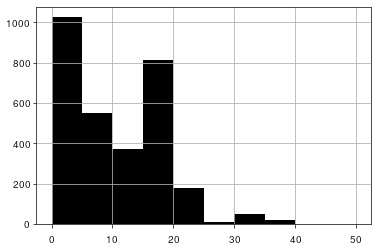

In [55]:
df['parleave_objective_length_women_inv'].hist(color='black'), df['parleave_objective_length_women_inv'].mean()

In [56]:
# Overall satisfaction: Women and Men, by whether they have kids
thrs = 4 #1verynot,2somewhatnot,3eh,4somewhatyeh,5verywoo

print('Women:')
temp = df
yes_kids = temp[(temp.children == 2.) & (temp.gender_ans == 1) & (temp.isyoung)].sat_overall.dropna().values
no_kids = temp[(temp.children == 1.) & (temp.gender_ans == 1) & (temp.isyoung)].sat_overall.dropna().values
print('y:', np.sum(yes_kids >= thrs)/len(yes_kids))
print('n:', np.sum(no_kids >= thrs)/len(no_kids))
table = np.array([[np.sum(yes_kids >= thrs), np.sum(yes_kids < thrs)],
                  [np.sum(no_kids >= thrs), np.sum(no_kids < thrs)]])
print('pval:', stats.chi2_contingency(table, correction=False)[1])
print('ttest:', stats.ttest_ind(yes_kids, no_kids))
print(table)

print('\nMen:')
yes_kids = temp[(temp.children == 2.) & (temp.gender_ans == 2) & (temp.isyoung)].sat_overall.dropna().values
no_kids = temp[(temp.children == 1.) & (temp.gender_ans == 2) & (temp.isyoung)].sat_overall.dropna().values
print('y:', np.sum(yes_kids >= thrs)/len(yes_kids))
print('n:', np.sum(no_kids >= thrs)/len(no_kids))
table = np.array([[np.sum(yes_kids >= thrs), np.sum(yes_kids < thrs)],
                  [np.sum(no_kids >= thrs), np.sum(no_kids < thrs)]])
print('pval:', stats.chi2_contingency(table, correction=False)[1])
print('ttest:', stats.ttest_ind(yes_kids, no_kids))
print(table)

Women:
y: 0.6716417910447762
n: 0.7266666666666667
pval: 0.3120954124832304
ttest: Ttest_indResult(statistic=-0.8632471434261657, pvalue=0.3887351794166638)
[[ 90  44]
 [109  41]]

Men:
y: 0.7799227799227799
n: 0.7899159663865546
pval: 0.7865699447017274
ttest: Ttest_indResult(statistic=-0.2193333814843534, pvalue=0.8264807720425502)
[[202  57]
 [188  50]]


In [57]:
# Overall satisfaction: Women and Men, by whether they have kids
thrs = 4 #1verynot,2somewhatnot,3eh,4somewhatyeh,5verywoo
for field in ['Computer Science', 'Business', 'History']:
    print('\n', field.upper())
    print('Women:')
    temp = df[df.likely_department == field]
    yes_kids = temp[(temp.children == 2.) & (temp.gender_ans == 1) & (temp.isyoung)].sat_overall.dropna().values
    no_kids = temp[(temp.children == 1.) & (temp.gender_ans == 1) & (temp.isyoung)].sat_overall.dropna().values
    print('y:', np.sum(yes_kids >= thrs)/len(yes_kids), len(yes_kids))
    print('n:', np.sum(no_kids >= thrs)/len(no_kids), len(no_kids))
    table = np.array([[np.sum(yes_kids >= thrs), np.sum(yes_kids < thrs)],
                      [np.sum(no_kids >= thrs), np.sum(no_kids < thrs)]])
    print('pval:', stats.chi2_contingency(table, correction=False)[1])
    print('ttest:', stats.ttest_ind(yes_kids, no_kids))
    print(table)

    print('\nMen:')
    yes_kids = temp[(temp.children == 2.) & (temp.gender_ans == 2) & (temp.isyoung)].sat_overall.dropna().values
    no_kids = temp[(temp.children == 1.) & (temp.gender_ans == 2) & (temp.isyoung)].sat_overall.dropna().values
    print('y:', np.sum(yes_kids >= thrs)/len(yes_kids), len(yes_kids))
    print('n:', np.sum(no_kids >= thrs)/len(no_kids), len(no_kids))
    table = np.array([[np.sum(yes_kids >= thrs), np.sum(yes_kids < thrs)],
                      [np.sum(no_kids >= thrs), np.sum(no_kids < thrs)]])
    print('pval:', stats.chi2_contingency(table, correction=False)[1])
    print('ttest:', stats.ttest_ind(yes_kids, no_kids))
    print(table)


 COMPUTER SCIENCE
Women:
y: 0.5833333333333334 24
n: 0.7 40
pval: 0.34143108509724895
ttest: Ttest_indResult(statistic=-2.044992889903334, pvalue=0.04510616168303179)
[[14 10]
 [28 12]]

Men:
y: 0.7837837837837838 111
n: 0.816 125
pval: 0.5362199948669628
ttest: Ttest_indResult(statistic=-0.6323350544208087, pvalue=0.527785321543158)
[[ 87  24]
 [102  23]]

 BUSINESS
Women:
y: 0.68 75
n: 0.7205882352941176 68
pval: 0.5970898096571966
ttest: Ttest_indResult(statistic=-1.0548040852866485, pvalue=0.2933190118330859)
[[51 24]
 [49 19]]

Men:
y: 0.7758620689655172 116
n: 0.7866666666666666 75
pval: 0.8602447562405283
ttest: Ttest_indResult(statistic=-0.04599663064714112, pvalue=0.9633614992722856)
[[90 26]
 [59 16]]

 HISTORY
Women:
y: 0.7142857142857143 35
n: 0.7619047619047619 42
pval: 0.6351464414161203
ttest: Ttest_indResult(statistic=0.7413989184462783, pvalue=0.46076683793101214)
[[25 10]
 [32 10]]

Men:
y: 0.78125 32
n: 0.7105263157894737 38
pval: 0.5000321724560941
ttest: Ttest_ind

## Does parenthood relate to productivity goal setting?

In [58]:
print('Women')
for field in ['Computer Science', 'Business', 'History']:
    print('\n', field.upper())
    
    temp = df[df.likely_department == field]
    print('w/ kids (N = %d): %f' %
           (len(temp[(temp.gender_ans == 1) & (temp.hasunder10) & temp.isyoung].aim_avg.dropna()),
            temp[(temp.gender_ans == 1) & (temp.hasunder10) & temp.isyoung].aim_avg.dropna().mean()),
          '\tw/o kids (N = %d): %f' % 
           (len(temp[(temp.gender_ans == 1) & ~(temp.hasunder10) & temp.isyoung].aim_avg.dropna()),
            temp[(temp.gender_ans == 1) & ~(temp.hasunder10) & temp.isyoung].aim_avg.dropna().mean()))

    print(ttest_ind(temp[(temp.gender_ans == 1) & (temp.hasunder10) & temp.isyoung].aim_avg.dropna(),
                    temp[(temp.gender_ans == 1) & ~(temp.hasunder10) & temp.isyoung].aim_avg.dropna(), 
                    equal_var=False))

Women

 COMPUTER SCIENCE
w/ kids (N = 25): 8.180000 	w/o kids (N = 38): 9.210526
Ttest_indResult(statistic=-0.9509867342443643, pvalue=0.3455427215823108)

 BUSINESS
w/ kids (N = 61): 3.508197 	w/o kids (N = 65): 3.623077
Ttest_indResult(statistic=-0.37458631153602406, pvalue=0.708616785393728)

 HISTORY
w/ kids (N = 33): 2.803030 	w/o kids (N = 39): 3.051282
Ttest_indResult(statistic=-0.8249430036962716, pvalue=0.4122101314060499)


In [59]:
print('Men')
for field in ['Computer Science', 'Business', 'History']:
    print('\n', field.upper())
    
    temp = df[df.likely_department == field]
    print('w/ kids (N = %d): %f' %
           (len(temp[(temp.gender_ans == 2) & (temp.hasunder10) & temp.isyoung].aim_avg.dropna()),
            temp[(temp.gender_ans == 2) & (temp.hasunder10) & temp.isyoung].aim_avg.dropna().mean()),
          '\tw/o kids (N = %d): %f' % 
           (len(temp[(temp.gender_ans == 2) & ~(temp.hasunder10) & temp.isyoung].aim_avg.dropna()),
            temp[(temp.gender_ans == 2) & ~(temp.hasunder10) & temp.isyoung].aim_avg.dropna().mean()))

    print(ttest_ind(temp[(temp.gender_ans == 2) & (temp.hasunder10) & temp.isyoung].aim_avg.dropna(),
                    temp[(temp.gender_ans == 2) & ~(temp.hasunder10) & temp.isyoung].aim_avg.dropna(), 
                    equal_var=False))

Men

 COMPUTER SCIENCE
w/ kids (N = 112): 9.450893 	w/o kids (N = 124): 8.451613
Ttest_indResult(statistic=1.7873539156380835, pvalue=0.07520453460409453)

 BUSINESS
w/ kids (N = 101): 3.905941 	w/o kids (N = 69): 3.739130
Ttest_indResult(statistic=0.45364922392864254, pvalue=0.6506856706290274)

 HISTORY
w/ kids (N = 27): 3.092593 	w/o kids (N = 33): 3.272727
Ttest_indResult(statistic=-0.5548796043187793, pvalue=0.5816112752592251)


In [60]:
for field in ['Computer Science', 'Business', 'History']:
    print('\n', field.upper())
    temp = df[df.likely_department == field]

    expectations = pd.DataFrame([], columns = ['likely', 'expected', 'aim_avg'], 
                                index = ['wchild', 'wnochild', 'mchild', 'mnochild'])

    for prefix, aka in [('des', 'likely'), ('inj', 'expected')]: # likely, expected
        labels = ['%snorm_wchild', '%snorm_wnochild', '%snorm_mchild', '%snorm_mnochild']
        expectations[aka] = [np.round(temp[(temp.isyoung)][label % prefix].mean(), decimals=2) for \
                             label in labels]
    
    print('Expected parenthood disadvantage')
    print((temp['desnorm_wnochild'] - temp['desnorm_wchild']).mean(),
          (temp['desnorm_mnochild'] - temp['desnorm_mchild']).mean())
    print(stats.ttest_1samp((temp['desnorm_wnochild'] - temp['desnorm_wchild']).dropna(), popmean=0))
    print(stats.ttest_1samp((temp['desnorm_mnochild'] - temp['desnorm_mchild']).dropna(), popmean=0), '\n')
    
    print('Expected motherhood penalty by respondent gender')
    print((temp[temp.gender_ans == 1]['desnorm_wnochild'] - temp[temp.gender_ans == 1]['desnorm_wchild']).mean(),
      (temp[temp.gender_ans == 2]['desnorm_wnochild'] - temp[temp.gender_ans == 2]['desnorm_wchild']).mean())
    print(stats.ttest_ind(
    (temp[temp.gender_ans == 1]['desnorm_wnochild'] - temp[temp.gender_ans == 1]['desnorm_wchild']).dropna(),
    (temp[temp.gender_ans == 2]['desnorm_wnochild'] - temp[temp.gender_ans == 2]['desnorm_wchild']).dropna()), '\n')
    
    print('Expected fatherhood penalty by respondent gender')
    print((temp[temp.gender_ans == 1]['desnorm_mnochild'] - temp[temp.gender_ans == 1]['desnorm_mchild']).mean(),
      (temp[temp.gender_ans == 2]['desnorm_mnochild'] - temp[temp.gender_ans == 2]['desnorm_mchild']).mean())
    print(stats.ttest_ind(
    (temp[temp.gender_ans == 1]['desnorm_mnochild'] - temp[temp.gender_ans == 1]['desnorm_mchild']).dropna(),
    (temp[temp.gender_ans == 2]['desnorm_mnochild'] - temp[temp.gender_ans == 2]['desnorm_mchild']).dropna()), '\n')
        
    print('Expected vs. likely for mothers')
    y = temp[(temp.gender_ans == 1)]
    #print(y.injnorm_wchild.dropna().mean(), y.desnorm_wchild.dropna().mean())
    y = y.desnorm_wchild < y.injnorm_wchild
    y = y.dropna().values

    n = temp[(temp.gender_ans == 2)]
    #print(n.injnorm_wchild.dropna().mean(), n.desnorm_wchild.dropna().mean())
    n = n.desnorm_wchild < n.injnorm_wchild
    n = n.dropna().values

    cont_tab = np.array([[np.sum(n == 0), np.sum(n == 1)],
                         [np.sum(y == 0), np.sum(y == 1)]])

    print('frac of women who think expected exceeds likely: %.4f' % y.mean())
    print('frac of men who think expected exceeds likely: %.4f' % n.mean())
    print('pval:', stats.chi2_contingency(cont_tab)[1], '\n')
    
    print('Expected vs. likely for fathers')
    y = temp[(temp.gender_ans == 1)]
    #print(y.injnorm_wchild.dropna().mean(), y.desnorm_wchild.dropna().mean())
    y = y.desnorm_mchild < y.injnorm_mchild
    y = y.dropna().values

    n = temp[(temp.gender_ans == 2)]
    #print(n.injnorm_wchild.dropna().mean(), n.desnorm_wchild.dropna().mean())
    n = n.desnorm_mchild < n.injnorm_mchild
    n = n.dropna().values

    cont_tab = np.array([[np.sum(n == 0), np.sum(n == 1)],
                         [np.sum(y == 0), np.sum(y == 1)]])

    print('frac of women who think expected exceeds likely: %.4f' % y.mean())
    print('frac of men who think expected exceeds likely: %.4f' % n.mean())
    print('pval:', stats.chi2_contingency(cont_tab)[1], '\n')
    
    goals = [];
    for g, has in [(1, True), (1, False), (2, True), (2, False)]:
        goals.append(np.round(temp[(temp.gender_ans == g) & (temp.hasunder10 == has) & \
                                   (temp.isyoung)].aim_avg.mean(), decimals=2))

#     reality = []
#     for g, has in [(1, True), (1, False), (2, True), (2, False)]:
#         group = temp[(temp.gender_ans == g) & (temp.hasunder10 == has) & \
#                    (temp.isyoung) & (len(temp.dblp_pubs) > 0)].dblp_pubs.dropna()

#         count_pubs = []
#         for row in group:
#             count_pubs.append((sum([(each[0] == 2018) or (each[0] == 2019) for each in row \
#                                     if (len(each) > 0) & (type(each[0]) is int)])))

#         reality.append(np.round(np.mean(count_pubs), decimals=2))

    expectations['aim_avg'] = goals
#     expectations['reality'] = reality

    print(expectations.to_latex())


 COMPUTER SCIENCE
Expected parenthood disadvantage
1.1456736035049289 0.7130339539978094
Ttest_1sampResult(statistic=21.308081840850683, pvalue=4.438211815375564e-82)
Ttest_1sampResult(statistic=12.714246223208203, pvalue=3.267283197107418e-34) 

Expected motherhood penalty by respondent gender
1.706989247311828 0.9993084370677732
Ttest_indResult(statistic=5.380189080167122, pvalue=9.474647502517691e-08) 

Expected fatherhood penalty by respondent gender
0.8279569892473119 0.6957123098201936
Ttest_indResult(statistic=0.9556456380736031, pvalue=0.3395059295235192) 

Expected vs. likely for mothers
frac of women who think expected exceeds likely: 0.4632
frac of men who think expected exceeds likely: 0.3345
pval: 0.00038186283903742326 

Expected vs. likely for fathers
frac of women who think expected exceeds likely: 0.1732
frac of men who think expected exceeds likely: 0.2489
pval: 0.0194545004911891 

\begin{tabular}{lrrr}
\toprule
{} &  likely &  expected &  aim\_avg \\
\midrule
wchil

In [61]:
df['discipline'] = df.likely_department
expectations_export = df[df.isyoung & df.resp_gender.isin(['M', 'F'])][['discipline', 'desnorm_wchild', 
    'desnorm_wnochild', 'desnorm_mchild', 'desnorm_mnochild', 'injnorm_wchild', 'injnorm_wnochild', 
    'injnorm_mchild', 'injnorm_mnochild', 'aim_avg', 'resp_gender', 'hasunder10']]
expectations_export.to_csv('../data/research_expectations_young_faculty.tsv', index=False, sep='\t')
# expectations_export.groupby(['discipline'])[['desnorm_wchild', 'desnorm_wnochild', 'desnorm_mchild', 
#                                              'desnorm_mnochild', 'injnorm_wchild', 'injnorm_wnochild', 
#                                              'injnorm_mchild', 'injnorm_mnochild']].mean()
# expectations_export.groupby(['discipline', 'resp_gender', 'hasunder10']).aim_avg.mean()

In [62]:
temp = df
       
print('Expected vs. likely for mothers')
y = temp[(temp.gender_ans == 1)]
#print(y.injnorm_wchild.dropna().mean(), y.desnorm_wchild.dropna().mean())
y = y.desnorm_wchild < y.injnorm_wchild
y = y.dropna().values

n = temp[(temp.gender_ans == 2)]
#print(n.injnorm_wchild.dropna().mean(), n.desnorm_wchild.dropna().mean())
n = n.desnorm_wchild < n.injnorm_wchild
n = n.dropna().values

cont_tab = np.array([[np.sum(n == 0), np.sum(n == 1)],
                         [np.sum(y == 0), np.sum(y == 1)]])

print('frac of women who think expected exceeds likely: %.4f' % y.mean())
print('frac of men who think expected exceeds likely: %.4f' % n.mean())
print('pval:', stats.chi2_contingency(cont_tab), '\n')
    
print('Expected vs. likely for fathers')
y = temp[(temp.gender_ans == 1)]
#print(y.injnorm_wchild.dropna().mean(), y.desnorm_wchild.dropna().mean())
y = y.desnorm_mchild < y.injnorm_mchild
y = y.dropna().values

n = temp[(temp.gender_ans == 2)]
#print(n.injnorm_wchild.dropna().mean(), n.desnorm_wchild.dropna().mean())
n = n.desnorm_mchild < n.injnorm_mchild
n = n.dropna().values

cont_tab = np.array([[np.sum(n == 0), np.sum(n == 1)],
                         [np.sum(y == 0), np.sum(y == 1)]])

print('frac of women who think expected exceeds likely: %.4f' % y.mean())
print('frac of men who think expected exceeds likely: %.4f' % n.mean())
print('pval:', stats.chi2_contingency(cont_tab), '\n')

Expected vs. likely for mothers
frac of women who think expected exceeds likely: 0.5416
frac of men who think expected exceeds likely: 0.3720
pval: (77.74778397448759, 1.1707454836330448e-18, 1, array([[1184.8182116,  882.1817884],
       [ 565.1817884,  420.8182116]])) 

Expected vs. likely for fathers
frac of women who think expected exceeds likely: 0.2201
frac of men who think expected exceeds likely: 0.2840
pval: (13.72563206324232, 0.00021154756297205266, 1, array([[1522.66066164,  544.33933836],
       [ 726.33933836,  259.66066164]])) 



### Relationship between expectations and parental leave policies

In [63]:
# If you’ve got a generous leave policy, faculty will estimate that the productivity differences 
# between parents and faculty without children will be greater, than estimates at universities 
# without generous leave? [Dig a little deeper here.]
prefix, aka = ('des', 'likely') # likely
labels = ['%snorm_wchild', '%snorm_wnochild', '%snorm_mchild', '%snorm_mnochild']

for field in ['Computer Science', 'Business', 'History']:
    print('\n>>>', field.upper())
    
    temp = df[(df.likely_department == field) & (df.parleave_objective_length_women_inv >= 10) & 
              (df.isyoung)]
    expectations_wleave = pd.DataFrame([], columns = ['likely'], 
                                       index = ['wchild', 'wnochild', 'mchild', 'mnochild'])
    expectations_wleave[aka] = [np.round(temp[label % prefix].mean(), decimals=2) for label in labels]
    mothers_wleave = (temp['desnorm_wnochild'] - temp['desnorm_wchild']).dropna()
    fathers_wleave = (temp['desnorm_mnochild'] - temp['desnorm_mchild']).dropna()
    
    print('w/ leave (N = %d): ' % len(temp))
    print(expectations_wleave)
 

    temp = df[(df.likely_department == field) & (df.parleave_objective_length_women_inv < 10) & (df.isyoung)]
    expectations_woleave = pd.DataFrame([], columns = ['likely'], 
                                        index = ['wchild', 'wnochild', 'mchild', 'mnochild'])

    expectations_woleave[aka] = [np.round(temp[label % prefix].mean(), decimals=2) for label in labels]
    mothers_woleave = (temp['desnorm_wnochild'] - temp['desnorm_wchild']).dropna()
    fathers_woleave = (temp['desnorm_mnochild'] - temp['desnorm_mchild']).dropna()
    
    print('\nw/o leave (N = %d): ' % len(temp))
    print(expectations_woleave)
    
    print((mothers_wleave.mean(), mothers_woleave.mean()), 
          ttest_ind(mothers_wleave, mothers_woleave, equal_var=False))
    print((fathers_wleave.mean(), fathers_woleave.mean()), 
          ttest_ind(fathers_wleave, fathers_woleave, equal_var=False))


>>> COMPUTER SCIENCE
w/ leave (N = 155): 
          likely
wchild      5.97
wnochild    7.34
mchild      7.30
mnochild    8.25

w/o leave (N = 167): 
          likely
wchild      5.47
wnochild    6.73
mchild      6.30
mnochild    7.25
(1.368421052631579, 1.2605633802816902) Ttest_indResult(statistic=0.4711497941021436, pvalue=0.6379556267279307)
(0.9473684210526315, 0.9436619718309859) Ttest_indResult(statistic=0.012963011423340545, pvalue=0.98967123510984)

>>> BUSINESS
w/ leave (N = 137): 
          likely
wchild      1.67
wnochild    2.27
mchild      2.22
mnochild    2.49

w/o leave (N = 152): 
          likely
wchild      1.53
wnochild    2.00
mchild      2.12
mnochild    2.36
(0.5995762711864406, 0.47674418604651164) Ttest_indResult(statistic=1.3136952501254233, pvalue=0.19018235361527663)
(0.2690677966101695, 0.24031007751937986) Ttest_indResult(statistic=0.41944341449696315, pvalue=0.6752607494844998)

>>> HISTORY
w/ leave (N = 61): 
          likely
wchild      1.26
wnochild  

In [64]:
# If you’ve got a generous leave policy, expectations of productivity for parents with young children 
# will be lower than comparable estimates at universities without generous leave. [Nope]
prefix, aka = ('inj', 'expected') # expected
labels = ['%snorm_wchild', '%snorm_wnochild', '%snorm_mchild', '%snorm_mnochild']

for field in ['Computer Science', 'Business', 'History']:
    print('\n>>>', field.upper())
    
    temp = df[(df.likely_department == field) & (df.parleave_objective_length_women_inv >= 10) & 
              (df.isyoung)]
    expectations_wleave = pd.DataFrame([], columns = ['expected'], 
                                       index = ['wchild', 'wnochild', 'mchild', 'mnochild'])
    expectations_wleave[aka] = [np.round(temp[label % prefix].mean(), decimals=2) for label in labels]
    mothers_wleave = temp['injnorm_wchild'].dropna(); fathers_wleave = temp['injnorm_mchild'].dropna();
    
    print('w/ leave (N = %d): ' % len(temp))
    print(expectations_wleave)
 

    temp = df[(df.likely_department == field) & (df.parleave_objective_length_women_inv < 10) & (df.isyoung)]
    expectations_woleave = pd.DataFrame([], columns = ['expected'], 
                                        index = ['wchild', 'wnochild', 'mchild', 'mnochild'])

    expectations_woleave[aka] = [np.round(temp[label % prefix].mean(), decimals=2) for label in labels]
    mothers_woleave = temp['injnorm_wchild'].dropna(); fathers_woleave = temp['injnorm_mchild'].dropna();
    
    print('\nw/o leave (N = %d): ' % len(temp))
    print(expectations_woleave)
    
    print((mothers_wleave.mean(), mothers_woleave.mean()), 
          ttest_ind(mothers_wleave, mothers_woleave, equal_var=False))
    print((fathers_wleave.mean(), fathers_woleave.mean()), 
          ttest_ind(fathers_wleave, fathers_woleave, equal_var=False))


>>> COMPUTER SCIENCE
w/ leave (N = 155): 
          expected
wchild        6.82
wnochild      7.39
mchild        7.36
mnochild      7.84

w/o leave (N = 167): 
          expected
wchild        6.21
wnochild      6.76
mchild        6.63
mnochild      7.18
(6.822222222222222, 6.20979020979021) Ttest_indResult(statistic=1.4869821564567445, pvalue=0.1382252220936917)
(7.355555555555555, 6.629370629370629) Ttest_indResult(statistic=1.6282278670655668, pvalue=0.10477104469382925)

>>> BUSINESS
w/ leave (N = 137): 
          expected
wchild        2.38
wnochild      2.64
mchild        2.58
mnochild      2.76

w/o leave (N = 152): 
          expected
wchild        2.43
wnochild      2.54
mchild        2.49
mnochild      2.53
(2.375, 2.4263565891472867) Ttest_indResult(statistic=-0.32860025267159987, pvalue=0.7427609694959028)
(2.5833333333333335, 2.488372093023256) Ttest_indResult(statistic=0.6098145487994073, pvalue=0.5425454968914694)

>>> HISTORY
w/ leave (N = 61): 
          expected
wchi

In [65]:
# If you’ve got a generous leave policy, parents will set lower goals for their productivity 
# in the next two years? [Nope]
for field in ['Computer Science', 'Business', 'History']:
    print('\n>>>', field.upper())
    print('WOMEN with children, early-career')
    
    temp = df[df.likely_department == field]
    print('w/ leave (N = %d): %f' %
           (len(temp[(temp.gender_ans == 1) & (temp.parleave_objective_length_women_inv >= 10) & 
                     temp.isyoung & temp.hasunder10].aim_avg.dropna()),
            temp[(temp.gender_ans == 1) & (temp.parleave_objective_length_women_inv >= 10) & 
                 temp.isyoung & temp.hasunder10].aim_avg.dropna().mean()),
          '\tw/o leave (N = %d): %f' % 
           (len(temp[(temp.gender_ans == 1) & (temp.parleave_objective_length_women_inv < 10) 
                     & temp.isyoung & temp.hasunder10].aim_avg.dropna()),
            temp[(temp.gender_ans == 1) & (temp.parleave_objective_length_women_inv < 10) 
                 & temp.isyoung & temp.hasunder10].aim_avg.dropna().mean()))

    print(ttest_ind(temp[(temp.gender_ans == 1) & (temp.parleave_objective_length_women_inv >= 10) & 
                         temp.isyoung & temp.hasunder10].aim_avg.dropna(),
                    temp[(temp.gender_ans == 1) & (temp.parleave_objective_length_women_inv < 10) & 
                         temp.isyoung & temp.hasunder10].aim_avg.dropna(), 
                    equal_var=False))
    
    print('\nMEN with children, early-career')
    print('w/ leave (N = %d): %f' %
           (len(temp[(temp.gender_ans == 2) & (temp.parleave_objective_length_women_inv >= 10) & 
                     temp.isyoung & temp.hasunder10].aim_avg.dropna()),
            temp[(temp.gender_ans == 2) & (temp.parleave_objective_length_women_inv >= 10) & 
                 temp.isyoung & temp.hasunder10].aim_avg.dropna().mean()),
          '\tw/o leave (N = %d): %f' % 
           (len(temp[(temp.gender_ans == 2) & (temp.parleave_objective_length_women_inv < 10) 
                     & temp.isyoung & temp.hasunder10].aim_avg.dropna()),
            temp[(temp.gender_ans == 2) & (temp.parleave_objective_length_women_inv < 10) 
                 & temp.isyoung & temp.hasunder10].aim_avg.dropna().mean()))

    print(ttest_ind(temp[(temp.gender_ans == 2) & (temp.parleave_objective_length_women_inv >= 10) & 
                         temp.isyoung & temp.hasunder10].aim_avg.dropna(),
                    temp[(temp.gender_ans == 2) & (temp.parleave_objective_length_women_inv < 10) & 
                         temp.isyoung & temp.hasunder10].aim_avg.dropna(), 
                    equal_var=False))


>>> COMPUTER SCIENCE
WOMEN with children, early-career
w/ leave (N = 14): 8.071429 	w/o leave (N = 11): 8.318182
Ttest_indResult(statistic=-0.2054526036257725, pvalue=0.8391952969311233)

MEN with children, early-career
w/ leave (N = 56): 9.526786 	w/o leave (N = 50): 9.520000
Ttest_indResult(statistic=0.008087018885064287, pvalue=0.9935631964627281)

>>> BUSINESS
WOMEN with children, early-career
w/ leave (N = 22): 3.636364 	w/o leave (N = 29): 3.551724
Ttest_indResult(statistic=0.15677243112108427, pvalue=0.8761344703397493)

MEN with children, early-career
w/ leave (N = 35): 3.971429 	w/o leave (N = 51): 3.470588
Ttest_indResult(statistic=1.3035480972239368, pvalue=0.19611020877575025)

>>> HISTORY
WOMEN with children, early-career
w/ leave (N = 14): 2.500000 	w/o leave (N = 16): 2.843750
Ttest_indResult(statistic=-0.8377418540790148, pvalue=0.4104367992017123)

MEN with children, early-career
w/ leave (N = 9): 3.000000 	w/o leave (N = 14): 3.035714
Ttest_indResult(statistic=-0.053

Local parental leave policies don’t impact expectations of others productivity or their own productivity, or we haven’t measured it. Norms are shaped by larger cultural forces, rather than local policy environments.

## What is the desired parental leave policy?

In [66]:
df[df.isyoung & df.gender_ans.isin([1, 2]) & \
   (df.children == 2)].parleave_elig_child1.value_counts(normalize=True)[0.0]

0.17206982543640897

In [67]:
df[df.isyoung & df.gender_ans.isin([1, 2]) & \
   (df.children == 2) & (df.parleave_elig_child1 >= 0)].parleave_elig_child1.value_counts(normalize=True)[0.0]

0.1760204081632653

In [68]:
#0: Don't know, 1 No, 2 Yes
print(df[df.isyoung & df.gender_ans.isin([1, 2]) & (df.children == 2) & (df.parleave_elig_child1 >= 0) &
     (df.likely_department == 'Computer Science') ].parleave_elig_child1.value_counts(normalize=True)[0.0],
      df[df.isyoung & df.gender_ans.isin([1, 2]) & (df.children == 2) & (df.parleave_elig_child1 >= 0) &
     (df.likely_department == 'History')].parleave_elig_child1.value_counts(normalize=True)[0.0],
      df[df.isyoung & df.gender_ans.isin([1, 2]) & (df.children == 2) & (df.parleave_elig_child1 >= 0) &
     (df.likely_department == 'Business')].parleave_elig_child1.value_counts(normalize=True)[0.0])

0.27972027972027974 0.06153846153846154 0.1358695652173913


In [69]:
# Do you think mean and women faculty should be offered equal parental leave?
#1: Men and women should be offered the same parental leave
df[df.parleave_neutral > 0].parleave_neutral.value_counts(normalize=True) 

1.0    0.480551
2.0    0.248881
4.0    0.151119
5.0    0.093976
6.0    0.025473
Name: parleave_neutral, dtype: float64

In [70]:
print(df[(df.parleave_neutral > 0) & (df['gender_ans'] == 1)].parleave_neutral.value_counts(normalize=True)[1.0], 
      df[(df.parleave_neutral > 0) & (df['gender_ans'] == 2)].parleave_neutral.value_counts(normalize=True)[1.0])

0.39135021097046413 0.522703818369453


In [71]:
# What do you think would be the ideal type of paid parental leave at your institution, if any?
#4: Full relief of duties, for %sweeks
df[df.parleave_ideal > 0].parleave_ideal.value_counts(normalize=True) 

4.0    0.683505
3.0    0.181443
5.0    0.052921
2.0    0.045017
1.0    0.023024
6.0    0.014089
Name: parleave_ideal, dtype: float64

In [72]:
print(df[(df.parleave_ideal > 0) & (df['gender_ans'] == 1)].parleave_ideal.value_counts(normalize=True)[4.0], 
      df[(df.parleave_ideal > 0) & (df['gender_ans'] == 2)].parleave_ideal.value_counts(normalize=True)[4.0])

0.7523709167544784 0.6512107161257084


## Overall parental leave figure

(205, 18)
205 200 199 0.9707317073170731
(199, 18) (1139, 442)
[0.7692307692307692, 0.7094017094017093]
(0.6147679156197993, 0.26935400038178814)
[0.5167785234899329, 0.253125]
(50.35842140186056, 1.1609345438391589e-11, 2, array([[103.86565272, 446.13434728],
       [ 34.747782  , 149.252218  ],
       [ 10.38656527,  44.61343473]]))
(4.873343821939827, 5.486250807362819e-07)


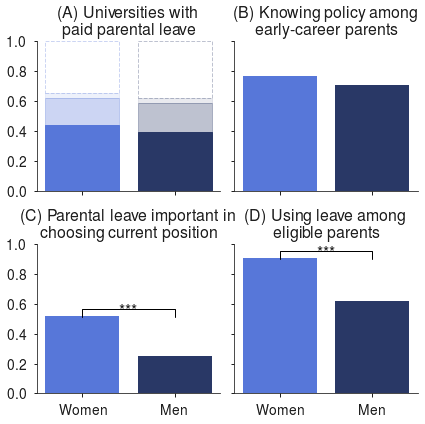

In [73]:
subset = df[df.likely_department == 'Computer Science']
plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK = color_mapping['CS']

policies = pd.read_csv('../data/survey_data/parental_leave/parental_leave_policies_apr_2018.tsv', sep='\t')
policies = policies.sort_values(inplace=False, by="rank", ascending=True)

# Restrict to the institutions we surveyed
policies = policies[policies.university_name != 'University of Massachusetts Dartmouth'] 
print(policies.shape)

universities = subset.university_name_standard.unique()
print(len(policies.university_name), len(universities), 
      len(set(universities).intersection(set(policies.university_name))), 
      len(set(universities).intersection(set(policies.university_name)))/205)

policies = policies[policies.university_name.isin(universities)]
print(policies.shape, subset.shape)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharey=True, sharex=True)

prop_man_term = sum([policy >= 10 for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_term = sum([policy >= 10 for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_term, prop_man_term], 
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])

prop_man_less_than_term = sum([(policy < 10) & (policy > 0) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_less_than_term = sum([(policy < 10) & (policy > 0) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_less_than_term, prop_man_less_than_term],
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.3,
          bottom = [prop_woman_term, prop_man_term])

prop_man_na = sum([np.isnan(policy) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_na = sum([np.isnan(policy) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_na, prop_man_na], 
          color=[plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.1,
          bottom = [prop_woman_less_than_term+prop_woman_term, prop_man_less_than_term+prop_man_term])

prop_man_zero = sum([(policy == 0) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_zero = sum([(policy == 0) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_zero, prop_man_zero], color=['white', 'white'],
          linestyle = '--',
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.3,
          bottom = [prop_woman_less_than_term+prop_woman_term+prop_woman_na, 
                    prop_man_less_than_term+prop_man_term+prop_man_na])

ax[0][0].set_xticks([0, 1])
ax[0][0].set_title('(A) Universities with\npaid parental leave', fontsize=plot_utils.TITLE_SIZE)
ax[0][0].set_xticklabels(['Women', 'Men'])
ax[0][0].set_ylim(0, 1)
plot_utils.finalize(ax[0][0])

heights = [
    1-subset[(subset['gender_ans'] == 1) & subset.isyoung & \
             (subset.children == 2)].parleave_elig_child1.value_counts(normalize=True)[0.0], 
    1-subset[(subset['gender_ans'] == 2) & subset.isyoung & \
             (subset.children == 2)].parleave_elig_child1.value_counts(normalize=True)[0.0]
]
bars = ax[0][1].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(heights)
print(proportions_ztest(
    [
        len(subset[(subset['gender_ans'] == 1) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()) - \
        subset[(subset['gender_ans'] == 1) & subset.isyoung & \
               (subset.children == 2)].parleave_elig_child1.value_counts()[0.0],
        len(subset[(subset['gender_ans'] == 2) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()) - \
        subset[(subset['gender_ans'] == 2) & subset.isyoung & \
               (subset.children == 2)].parleave_elig_child1.value_counts()[0.0]
    ], 
    [
        len(subset[(subset['gender_ans'] == 1) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()),
        len(subset[(subset['gender_ans'] == 2) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna())
    ], alternative='larger'))
# plot_utils.label_diff(ax[0][1], 0, 1, '*', [0, 1], heights)

ax[0][1].set_xticks([0, 1])
ax[0][1].set_title('(B) Knowing policy among\nearly-career parents ', fontsize=plot_utils.TITLE_SIZE)
ax[0][1].set_xticklabels(['Women', 'Men'])
ax[0][1].set_ylim(0, 1)
plot_utils.finalize(ax[0][1])

temp = subset[subset.gender_ans.isin([1, 2]) & (subset.current_parleave > 0) &
              (subset.current_parleave < 4)][['gender_ans', 'current_parleave']].dropna()
temp = temp.groupby(['gender_ans', 'current_parleave']).size().unstack().T
normed = temp.div(temp.sum(axis=0), axis=1)

heights = [normed[1][normed[1].index.isin([2, 3])].sum(),
           normed[2][normed[2].index.isin([2, 3])].sum()]
bars = ax[1][0].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(heights)
print(stats.chi2_contingency(temp.values, correction=False))
plot_utils.label_diff(ax[1][0], 0, 1, '***', [0, 1], heights)

ax[1][0].set_xticks([0, 1])
ax[1][0].set_title('(C) Parental leave important in\nchoosing current position', 
                   fontsize=plot_utils.TITLE_SIZE)
ax[1][0].set_xticklabels(['Women', 'Men'])
ax[1][0].set_ylim(0, 1)
plot_utils.finalize(ax[1][0])

women_offered_leave = subset[(subset.gender_ans == 1) & (subset.count_eligible > 0)]
men_offered_leave = subset[(subset.gender_ans == 2) & (subset.count_eligible > 0)]

heights = [sum(women_offered_leave.count_took_some_leave > 0)/len(women_offered_leave),
           sum(men_offered_leave.count_took_some_leave > 0)/len(men_offered_leave)]
bars = ax[1][1].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(proportions_ztest(
    [sum(women_offered_leave.count_took_some_leave > 0), sum(men_offered_leave.count_took_some_leave > 0)], 
    [len(women_offered_leave), len(men_offered_leave)], alternative='larger'))
plot_utils.label_diff(ax[1][1], 0, 1, '***', [0, 1], heights)


ax[1][1].set_xticks([0, 1])
ax[1][1].set_title('(D) Using leave among\neligible parents', fontsize=plot_utils.TITLE_SIZE)
ax[1][1].set_xticklabels(['Women', 'Men'])
ax[1][1].set_ylim(0, 1)
plot_utils.finalize(ax[1][1])

plt.tight_layout()
plt.savefig('../plots/descriptive/parental_leave_policy_cs.pdf', dpi=1000)

(205, 18)
205 113 93 0.8303571428571429
(93, 18) (1321, 442)
[0.8933333333333333, 0.853448275862069]
(0.7981095063347666, 0.2124034726501723)
[0.45933014354066987, 0.1282608695652174]
(88.56901156822528, 5.854414990125323e-20, 2, array([[160.57698057, 353.42301943],
       [ 37.17638266,  81.82361734],
       [ 11.24663677,  24.75336323]]))
(5.835698636198371, 2.6782819109372345e-09)


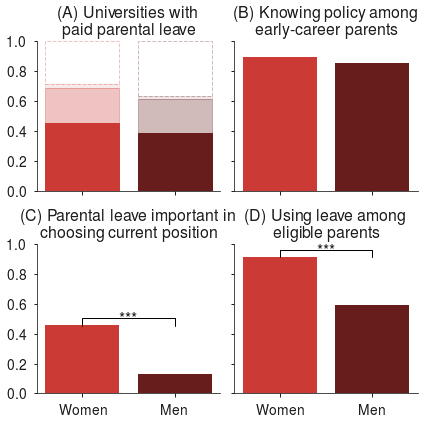

In [74]:
subset = df[df.likely_department == 'Business']
plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK = color_mapping['Business']

policies = pd.read_csv('../data/survey_data/parental_leave/parental_leave_policies_apr_2018.tsv', sep='\t')
policies = policies.sort_values(inplace=False, by="rank", ascending=True)

# Restrict to the institutions we surveyed
policies = policies[policies.university_name != 'University of Massachusetts Dartmouth'] 
print(policies.shape)

universities = subset.university_name_standard.unique()
print(len(policies.university_name), len(universities), 
      len(set(universities).intersection(set(policies.university_name))), 
      len(set(universities).intersection(set(policies.university_name)))/112)

policies = policies[policies.university_name.isin(universities)]
print(policies.shape, subset.shape)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharey=True, sharex=True)

prop_man_term = sum([policy >= 10 for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_term = sum([policy >= 10 for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_term, prop_man_term], 
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])

prop_man_less_than_term = sum([(policy < 10) & (policy > 0) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_less_than_term = sum([(policy < 10) & (policy > 0) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_less_than_term, prop_man_less_than_term],
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.3,
          bottom = [prop_woman_term, prop_man_term])

prop_man_na = sum([np.isnan(policy) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_na = sum([np.isnan(policy) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_na, prop_man_na], 
          color=[plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.1,
          bottom = [prop_woman_less_than_term+prop_woman_term, prop_man_less_than_term+prop_man_term])

prop_man_zero = sum([(policy == 0) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_zero = sum([(policy == 0) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_zero, prop_man_zero], color=['white', 'white'],
          linestyle = '--',
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.3,
          bottom = [prop_woman_less_than_term+prop_woman_term+prop_woman_na, 
                    prop_man_less_than_term+prop_man_term+prop_man_na])

ax[0][0].set_xticks([0, 1])
ax[0][0].set_title('(A) Universities with\npaid parental leave', fontsize=plot_utils.TITLE_SIZE)
ax[0][0].set_xticklabels(['Women', 'Men'])
ax[0][0].set_ylim(0, 1)
plot_utils.finalize(ax[0][0])

heights = [
    1-subset[(subset['gender_ans'] == 1) & subset.isyoung & \
             (subset.children == 2)].parleave_elig_child1.value_counts(normalize=True)[0.0], 
    1-subset[(subset['gender_ans'] == 2) & subset.isyoung & \
             (subset.children == 2)].parleave_elig_child1.value_counts(normalize=True)[0.0]
]
bars = ax[0][1].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(heights)
print(proportions_ztest(
    [
        len(subset[(subset['gender_ans'] == 1) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()) - \
        subset[(subset['gender_ans'] == 1) & subset.isyoung & \
               (subset.children == 2)].parleave_elig_child1.value_counts()[0.0],
        len(subset[(subset['gender_ans'] == 2) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()) - \
        subset[(subset['gender_ans'] == 2) & subset.isyoung & \
               (subset.children == 2)].parleave_elig_child1.value_counts()[0.0]
    ], 
    [
        len(subset[(subset['gender_ans'] == 1) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()),
        len(subset[(subset['gender_ans'] == 2) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna())
    ], alternative='larger'))
# plot_utils.label_diff(ax[0][1], 0, 1, '*', [0, 1], heights)

ax[0][1].set_xticks([0, 1])
ax[0][1].set_title('(B) Knowing policy among\nearly-career parents ', fontsize=plot_utils.TITLE_SIZE)
ax[0][1].set_xticklabels(['Women', 'Men'])
ax[0][1].set_ylim(0, 1)
plot_utils.finalize(ax[0][1])

temp = subset[subset.gender_ans.isin([1, 2]) & (subset.current_parleave > 0) &
              (subset.current_parleave < 4)][['gender_ans', 'current_parleave']].dropna()
temp = temp.groupby(['gender_ans', 'current_parleave']).size().unstack().T
normed = temp.div(temp.sum(axis=0), axis=1)

heights = [normed[1][normed[1].index.isin([2, 3])].sum(),
           normed[2][normed[2].index.isin([2, 3])].sum()]
bars = ax[1][0].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(heights)
print(stats.chi2_contingency(temp.values, correction=False))
plot_utils.label_diff(ax[1][0], 0, 1, '***', [0, 1], heights)

ax[1][0].set_xticks([0, 1])
ax[1][0].set_title('(C) Parental leave important in\nchoosing current position', 
                   fontsize=plot_utils.TITLE_SIZE)
ax[1][0].set_xticklabels(['Women', 'Men'])
ax[1][0].set_ylim(0, 1)
plot_utils.finalize(ax[1][0])

women_offered_leave = subset[(subset.gender_ans == 1) & (subset.count_eligible > 0)]
men_offered_leave = subset[(subset.gender_ans == 2) & (subset.count_eligible > 0)]

heights = [sum(women_offered_leave.count_took_some_leave > 0)/len(women_offered_leave),
           sum(men_offered_leave.count_took_some_leave > 0)/len(men_offered_leave)]
bars = ax[1][1].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(proportions_ztest(
    [sum(women_offered_leave.count_took_some_leave > 0), sum(men_offered_leave.count_took_some_leave > 0)], 
    [len(women_offered_leave), len(men_offered_leave)], alternative='larger'))
plot_utils.label_diff(ax[1][1], 0, 1, '***', [0, 1], heights)


ax[1][1].set_xticks([0, 1])
ax[1][1].set_title('(D) Using leave among\neligible parents', fontsize=plot_utils.TITLE_SIZE)
ax[1][1].set_xticklabels(['Women', 'Men'])
ax[1][1].set_ylim(0, 1)
plot_utils.finalize(ax[1][1])

plt.tight_layout()
plt.savefig('../plots/descriptive/parental_leave_policy_business.pdf', dpi=1000)

(205, 18)
205 140 115 0.7986111111111112
(115, 18) (992, 442)
[1, 0.875]
(2.1570298509241317, 0.015501669317670374)
gender_ans               1         2
current_parleave                    
1.0               0.577586  0.774545
2.0               0.301724  0.196364
3.0               0.120690  0.029091
[0.4224137931034483, 0.22545454545454544]
(27.71362433530925, 9.595396798337976e-07, 2, array([[158.78500986, 188.21499014],
       [ 56.74161736,  67.25838264],
       [ 16.47337278,  19.52662722]]))
[0.9274193548387096, 0.68]
(4.547688072596773, 2.7119222113880716e-06)


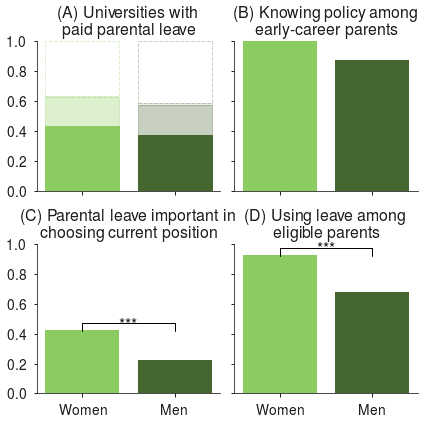

In [75]:
subset = df[df.likely_department == 'History']
plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK = color_mapping['History']

policies = pd.read_csv('../data/survey_data/parental_leave/parental_leave_policies_apr_2018.tsv', sep='\t')
policies = policies.sort_values(inplace=False, by="rank", ascending=True)

# Restrict to the institutions we surveyed
policies = policies[policies.university_name != 'University of Massachusetts Dartmouth'] 
print(policies.shape)

universities = subset.university_name_standard.unique()
print(len(policies.university_name), len(universities), 
      len(set(universities).intersection(set(policies.university_name))), 
      len(set(universities).intersection(set(policies.university_name)))/144)

policies = policies[policies.university_name.isin(universities)]
print(policies.shape, subset.shape)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharey=True, sharex=True)

prop_man_term = sum([policy >= 10 for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_term = sum([policy >= 10 for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_term, prop_man_term], 
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])

prop_man_less_than_term = sum([(policy < 10) & (policy > 0) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_less_than_term = sum([(policy < 10) & (policy > 0) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_less_than_term, prop_man_less_than_term],
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.3,
          bottom = [prop_woman_term, prop_man_term])

prop_man_na = sum([np.isnan(policy) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_na = sum([np.isnan(policy) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_na, prop_man_na], 
          color=[plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK],
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.1,
          bottom = [prop_woman_less_than_term+prop_woman_term, prop_man_less_than_term+prop_man_term])

prop_man_zero = sum([(policy == 0) for policy in policies.paid_leave_weeks_man])/len(policies.paid_leave_weeks_man)
prop_woman_zero = sum([(policy == 0) for policy in policies.paid_leave_weeks_woman])/len(policies.paid_leave_weeks_woman)
ax[0][0].bar([0, 1], [prop_woman_zero, prop_man_zero], color=['white', 'white'],
          linestyle = '--',
          edgecolor = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK], alpha=0.3,
          bottom = [prop_woman_less_than_term+prop_woman_term+prop_woman_na, 
                    prop_man_less_than_term+prop_man_term+prop_man_na])

ax[0][0].set_xticks([0, 1])
ax[0][0].set_title('(A) Universities with\npaid parental leave', fontsize=plot_utils.TITLE_SIZE)
ax[0][0].set_xticklabels(['Women', 'Men'])
ax[0][0].set_ylim(0, 1)
plot_utils.finalize(ax[0][0])

heights = [
    1-0, 
    1-subset[(subset['gender_ans'] == 2) & subset.isyoung & \
             (subset.children == 2)].parleave_elig_child1.value_counts(normalize=True)[0.0]
]
print(heights)
bars = ax[0][1].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(proportions_ztest(
    [
        len(subset[(subset['gender_ans'] == 1) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()) - 0,
        len(subset[(subset['gender_ans'] == 2) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()) - \
        subset[(subset['gender_ans'] == 2) & subset.isyoung & \
               (subset.children == 2)].parleave_elig_child1.value_counts()[0.0]
    ], 
    [
        len(subset[(subset['gender_ans'] == 1) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna()),
        len(subset[(subset['gender_ans'] == 2) & subset.isyoung & \
                   (subset.children == 2)].parleave_elig_child1.dropna())
    ], alternative='larger'))
# plot_utils.label_diff(ax[0][1], 0, 1, '*', [0, 1], heights)

ax[0][1].set_xticks([0, 1])
ax[0][1].set_title('(B) Knowing policy among\nearly-career parents ', fontsize=plot_utils.TITLE_SIZE)
ax[0][1].set_xticklabels(['Women', 'Men'])
ax[0][1].set_ylim(0, 1)
plot_utils.finalize(ax[0][1])

temp = subset[subset.gender_ans.isin([1,2]) & (subset.current_parleave > 0) &
              (subset.current_parleave < 4)][['gender_ans', 'current_parleave']].dropna()
temp = temp.groupby(['gender_ans', 'current_parleave']).size().unstack().T
normed = temp.div(temp.sum(axis=0), axis=1)
print(normed)

heights = [normed[1][normed[1].index.isin([2, 3])].sum(),
           normed[2][normed[2].index.isin([2, 3])].sum()]
bars = ax[1][0].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(heights)
print(stats.chi2_contingency(temp.values, correction=False))
plot_utils.label_diff(ax[1][0], 0, 1, '***', [0, 1], heights)

ax[1][0].set_xticks([0, 1])
ax[1][0].set_title('(C) Parental leave important in\nchoosing current position', 
                   fontsize=plot_utils.TITLE_SIZE)
ax[1][0].set_xticklabels(['Women', 'Men'])
ax[1][0].set_ylim(0, 1)
plot_utils.finalize(ax[1][0])

women_offered_leave = subset[(subset.gender_ans == 1) & (subset.count_eligible > 0)]
men_offered_leave = subset[(subset.gender_ans == 2) & (subset.count_eligible > 0)]

heights = [sum(women_offered_leave.count_took_some_leave > 0)/len(women_offered_leave),
           sum(men_offered_leave.count_took_some_leave > 0)/len(men_offered_leave)]
bars = ax[1][1].bar([0, 1], heights, color = [plot_utils.ACCENT_COLOR, plot_utils.ALMOST_BLACK])
print(heights)
print(proportions_ztest(
    [sum(women_offered_leave.count_took_some_leave > 0), sum(men_offered_leave.count_took_some_leave > 0)], 
    [len(women_offered_leave), len(men_offered_leave)], alternative='larger'))
plot_utils.label_diff(ax[1][1], 0, 1, '***', [0, 1], heights)


ax[1][1].set_xticks([0, 1])
ax[1][1].set_title('(D) Using leave among\neligible parents', fontsize=plot_utils.TITLE_SIZE)
ax[1][1].set_xticklabels(['Women', 'Men'])
ax[1][1].set_ylim(0, 1)
plot_utils.finalize(ax[1][1])

plt.tight_layout()
plt.savefig('../plots/descriptive/parental_leave_policy_history.pdf', dpi=1000)

In [76]:
df['took_some_leave'] = df.count_took_some_leave > 0
df['parleave_elig_first_child'] = df.parleave_elig_child1
df['younger_than_40'] = df.isyoung
parental_leave_summary = df[df.gender_ans.isin([1,2])][['discipline', 'resp_gender', 'younger_than_40', 
    'count_eligible', 'took_some_leave', 'current_parleave', 'parleave_elig_first_child', 'had_children']]

# parental_leave_summary[
#     parental_leave_summary.younger_than_40 & parental_leave_summary.had_children & 
#     (parental_leave_summary.parleave_elig_child1 >= 0)].groupby(
#     ['discipline', 'resp_gender']).parleave_elig_child1.value_counts(normalize=True)

# parental_leave_summary[(parental_leave_summary.current_parleave < 4) & 
#     (parental_leave_summary.current_parleave > 0)].groupby(
#     ['discipline', 'resp_gender']).current_parleave.value_counts(normalize=True)

# parental_leave_summary[(parental_leave_summary.count_eligible > 0)].groupby(
#     ['discipline', 'resp_gender']).took_some_leave.value_counts(normalize=True)

parental_leave_summary.to_csv('../data/overall_parental_leave.tsv', sep='\t', index=False)

## Basic summary of parental leave policies

In [77]:
policies = pd.read_csv('../data/survey_data/parental_leave/parental_leave_policies_apr_2018.tsv', sep='\t')
policies = policies.sort_values(inplace=False, by="rank", ascending=True)
policies = policies.reset_index(drop=True)
policies = policies.reset_index()

# Restrict to the institutions we surveyed
policies = policies[policies.university_name != 'University of Massachusetts Dartmouth'] 
print(policies.shape)

(205, 19)


In [78]:
# Consider only observed policies
obs = policies[policies.missing == 0]
print(len(obs), len(policies), 1. - (len(obs) / len(policies)))

198 205 0.034146341463414664


In [79]:
# What fraction of institutions have paid leave policies for women? For men?
print(np.sum(obs["paid_leave_weeks_woman"] > 0), 1. * np.sum(obs["paid_leave_weeks_woman"] > 0) / len(obs))
print(np.sum(obs["paid_leave_weeks_man"] > 0), 1. * np.sum(obs["paid_leave_weeks_man"] > 0) / len(obs))

126 0.6363636363636364
118 0.5959595959595959


In [80]:
# What fraction of instutions have *no* paid leave for women? For men?
print(np.sum(obs["paid_leave_weeks_woman"] == 0.), 1.*np.sum(obs["paid_leave_weeks_woman"] == 0.) / len(obs))
print(np.sum(obs["paid_leave_weeks_man"] == 0.), 1.*np.sum(obs["paid_leave_weeks_man"] == 0.) / len(obs))

72 0.36363636363636365
80 0.40404040404040403


In [81]:
# Conditioned on having paid leave, what's the average duration for women? For men?
for_w = obs[obs.paid_leave_weeks_woman > 0]["paid_leave_weeks_woman"]
for_m = obs[obs.paid_leave_weeks_man > 0]["paid_leave_weeks_man"]

print(np.mean(for_w), np.mean(for_m))
print(np.median(for_w), np.median(for_m))
stats.mannwhitneyu(for_w, for_m)

14.682539682539682 12.23728813559322
15.0 12.0


MannwhitneyuResult(statistic=6179.5, pvalue=0.010944678557877546)

In [82]:
# How many (and what fraction of) institutions have gender neutral policies?
offered_leave = obs[(obs.paid_leave_weeks_woman > 0) | (obs.paid_leave_weeks_man > 0)]
sames = np.sum(offered_leave["paid_leave_weeks_woman"].values == offered_leave["paid_leave_weeks_man"].values)
print(np.sum(sames), np.sum(sames) / len(obs))

85 0.4292929292929293


In [83]:
# Conditioned on having paid leave, how many institutions have gender neutral policies?
sames = np.sum(offered_leave["paid_leave_weeks_woman"].values == \
               offered_leave["paid_leave_weeks_man"].values)
print(np.sum(sames), np.sum(sames) / len(policies), np.sum(sames) / len(offered_leave))

85 0.4146341463414634 0.6746031746031746


In [84]:
# Conditioned on having paid leave, how many institutions have gender neutral policies?
1.*len(offered_leave[(offered_leave.relief_man == 'Not specified') | 
                     (offered_leave.relief_woman == 'Not specified')]) / len(offered_leave)

0.5476190476190477

## Instrumental variable

In [85]:
feature_set = ['gender_ans', 'chage1', 'chage2', 'chage3', 'prestige_frame']

# Parents who had at least one, and did not have more than three children
had_at_two_or_three_kids = df[~df.chage1.isna() & ~df.chage2.isna() & df.chage4.isna()].copy(deep=True)
mapping = {'prestige_inv': 'prestige_frame'}
had_at_two_or_three_kids.rename(columns=mapping, inplace=True)
yob = had_at_two_or_three_kids[feature_set].apply(pd.Series.value_counts, axis=1).fillna(0)

# Add indicator for observations which had children
had_twins_indicator = yob.apply(lambda x: x == 2, axis=1).any(1)
had_at_two_or_three_kids['had_twins'] = had_twins_indicator
had_at_two_or_three_kids['had_third_kid'] = 1.0*(~had_at_two_or_three_kids.chage3.isna())

# Remove 
had_at_two_or_three_kids = had_at_two_or_three_kids[(had_at_two_or_three_kids.had_twins | \
                                                     had_at_two_or_three_kids.chage3.isna())]

In [86]:
first_child_age = [];
chages = ['chage1', 'chage2', 'chage3', 'chage4', 'chage5', 'chage6', 'chage7', 'chage8', 'chage9'];
for i, row in had_at_two_or_three_kids.iterrows():
    first_child_age.append(np.min(row[chages]))
had_at_two_or_three_kids['first_child_birth'] = first_child_age 

In [87]:
women = had_at_two_or_three_kids[had_at_two_or_three_kids.gender_ans == 1]
df_w_had_twins = cohort_utils.compute_publication_trend(women[women.had_twins], -5, 10, adjusted=False)
df_w_had_not_twins = cohort_utils.compute_publication_trend(women[~women.had_twins], -5, 10, adjusted=False)

df_w_had_twins['had_twins'] = True
df_w_had_not_twins['had_twins'] = False

df_w_had_twins['cumulative'] = df_w_had_twins.groupby(['i'])['y'].cumsum()
df_w_had_not_twins['cumulative'] = df_w_had_not_twins.groupby(['i'])['y'].cumsum()

In [88]:
men = had_at_two_or_three_kids[had_at_two_or_three_kids.gender_ans == 2]
df_m_had_twins = cohort_utils.compute_publication_trend(men[men.had_twins], -5, 10, adjusted=False)
df_m_had_not_twins = cohort_utils.compute_publication_trend(men[~men.had_twins], -5, 10, adjusted=False)

df_m_had_twins['had_twins'] = True
df_m_had_not_twins['had_twins'] = False

df_m_had_twins['cumulative'] = df_m_had_twins.groupby(['i'])['y'].cumsum()
df_m_had_not_twins['cumulative'] = df_m_had_not_twins.groupby(['i'])['y'].cumsum()

In [89]:
print(
    ('WOMEN', len(df_w_had_twins['i'].unique()), df_w_had_twins[df_w_had_twins['t'] == 0]['age'].mean(), 
       len(df_w_had_not_twins['i'].unique()), df_w_had_not_twins[df_w_had_not_twins['t'] == 0]['age'].mean()), 
    ('MEN', len(df_m_had_twins['i'].unique()), df_m_had_twins[df_m_had_twins['t'] == 0]['age'].mean(),
       len(df_m_had_not_twins['i'].unique()), df_m_had_not_twins[df_m_had_not_twins['t'] == 0]['age'].mean())
)

('WOMEN', 4, 36.0, 60, 32.65) ('MEN', 16, 34.1875, 291, 32.63230240549828)


In [90]:
ages = []
ages.extend(df_w_had_twins[df_w_had_twins['t'] == 0]['age'].values)
ages.extend(df_m_had_twins[df_m_had_twins['t'] == 0]['age'].values)
np.mean(ages)

34.55

In [91]:
ages = []
ages.extend(df_w_had_not_twins[df_w_had_not_twins['t'] == 0]['age'].values)
ages.extend(df_w_had_not_twins[df_w_had_not_twins['t'] == 0]['age'].values)
np.mean(ages)

32.65

## House versus work hours

In [92]:
df['house_hours_parsed'] = pd.to_numeric(df.househours, errors='coerce')

In [93]:
print(
    df[(df.gender_ans == 1) & (df.house_hours_parsed > 0)].house_hours_parsed.mean(), 
    df[(df.gender_ans == 2) & (df.house_hours_parsed > 0)].house_hours_parsed.mean())

22.53244078269825 18.10919940328195


In [94]:
print(
    df[(df.gender_ans == 1) & (df.house_hours_parsed > 0) & (df.children == 2)].house_hours_parsed.mean(), 
    df[(df.gender_ans == 2) & (df.house_hours_parsed > 0) & (df.children == 2)].house_hours_parsed.mean())

27.81159420289855 20.388


In [95]:
ttest_ind(
    df[(df.gender_ans == 1) & (df.house_hours_parsed > 0) & (df.children == 2)].house_hours_parsed,
    df[(df.gender_ans == 2) & (df.house_hours_parsed > 0) & (df.children == 2)].house_hours_parsed,
    equal_var=False
)

Ttest_indResult(statistic=10.671808567644215, pvalue=3.191716981056978e-25)

In [96]:
df['work_hours_parsed'] = pd.to_numeric(df.workhours, errors='coerce')

In [97]:
print(
    df[(df.gender_ans == 1) & (df.work_hours_parsed > 0)].work_hours_parsed.mean(),
    df[(df.gender_ans == 2) & (df.work_hours_parsed > 0)].work_hours_parsed.mean())

51.34886128364389 51.33138116154222


In [98]:
print(
    df[(df.gender_ans == 1) & (df.work_hours_parsed > 0) & (df.children == 2)].work_hours_parsed.mean(),
    df[(df.gender_ans == 2) & (df.work_hours_parsed > 0) & (df.children == 2)].work_hours_parsed.mean())

49.13636363636363 50.318897637795274
